In [ ]:
!pip install pykalman

In [ ]:
%pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow keras hmmlearn statsmodels ta transformers torch tqdm

In [1]:
%pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from pykalman import KalmanFilter
from hmmlearn.hmm import GaussianHMM
from sklearn.mixture import BayesianGaussianMixture
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.


c:\Users\viswa\GithubClonedRepos\PAML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[*********************100%***********************]  1 of 1 completed


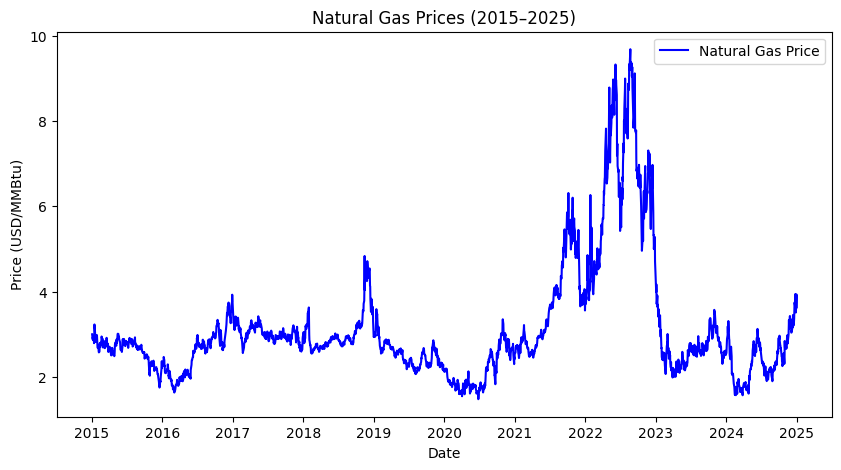

Price,NATURAL_GAS
Ticker,NG=F
Date,
2015-01-02,3.003
2015-01-05,2.882
2015-01-06,2.938
2015-01-07,2.871
2015-01-08,2.927


In [2]:
# --- Load Natural Gas Prices ---
df = yf.download("NG=F", start="2015-01-01", end="2025-01-01")  # NYMEX Natural Gas Futures
df = df[["Close"]].rename(columns={"Close": "NATURAL_GAS"})
df.dropna(inplace=True)

plt.figure(figsize=(10,5))
plt.plot(df["NATURAL_GAS"], label="Natural Gas Price", color='blue')
plt.title("Natural Gas Prices (2015–2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD/MMBtu)")
plt.legend()
plt.show()

df.head()

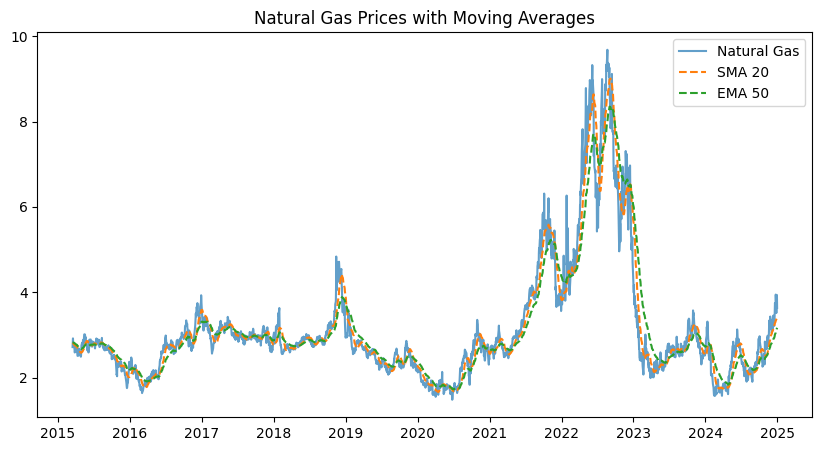

Price,NATURAL_GAS,RSI,MACD,Signal_Line,SMA_20,EMA_50
Ticker,NG=F,,,,,
Date,,,,,,
2024-12-24,3.946,69.840164,0.200483,0.152381,3.33695,3.076040
2024-12-26,3.715,61.308728,0.202842,0.162474,3.35115,3.101097
2024-12-27,3.514,55.011639,0.186345,0.167248,3.36665,3.117289
2024-12-30,3.936,63.490297,0.204960,0.174790,3.39530,3.149395
2024-12-31,3.633,55.414825,0.193038,0.178440,3.41630,3.168360


In [3]:
# --- 4. Technical Indicators (RSI, MACD, SMA, EMA) ---

# Ensure the 'NATURAL_GAS' column is a 1-D Series
natural_gas_series = pd.Series(np.ravel(df["NATURAL_GAS"].values), index=df.index)

# RSI
df["RSI"] = RSIIndicator(close=natural_gas_series, window=14).rsi()

# MACD
macd_obj = MACD(close=natural_gas_series)
df["MACD"] = pd.Series(np.ravel(macd_obj.macd().values), index=df.index)
df["Signal_Line"] = pd.Series(np.ravel(macd_obj.macd_signal().values), index=df.index)

# Moving Averages
df["SMA_20"] = SMAIndicator(close=natural_gas_series, window=20).sma_indicator()
df["EMA_50"] = EMAIndicator(close=natural_gas_series, window=50).ema_indicator()

# Clean up
df.dropna(inplace=True)

# Plot
plt.figure(figsize=(10,5))
plt.plot(df["NATURAL_GAS"], label="Natural Gas", alpha=0.7)
plt.plot(df["SMA_20"], label="SMA 20", linestyle="--")
plt.plot(df["EMA_50"], label="EMA 50", linestyle="--")
plt.title("Natural Gas Prices with Moving Averages")
plt.legend()
plt.show()

df.tail()

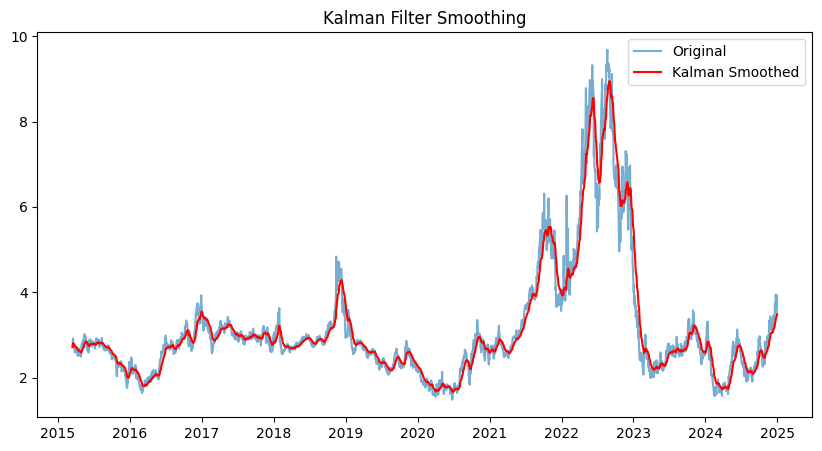

In [4]:
# --- Kalman Filter Smoothing ---
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=df["NATURAL_GAS"].values[0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

state_means, _ = kf.filter(df["NATURAL_GAS"].values)
df["Kalman_Smoothed"] = state_means

plt.figure(figsize=(10,5))
plt.plot(df["NATURAL_GAS"], label="Original", alpha=0.6)
plt.plot(df["Kalman_Smoothed"], label="Kalman Smoothed", color='red')
plt.legend()
plt.title("Kalman Filter Smoothing")
plt.show()

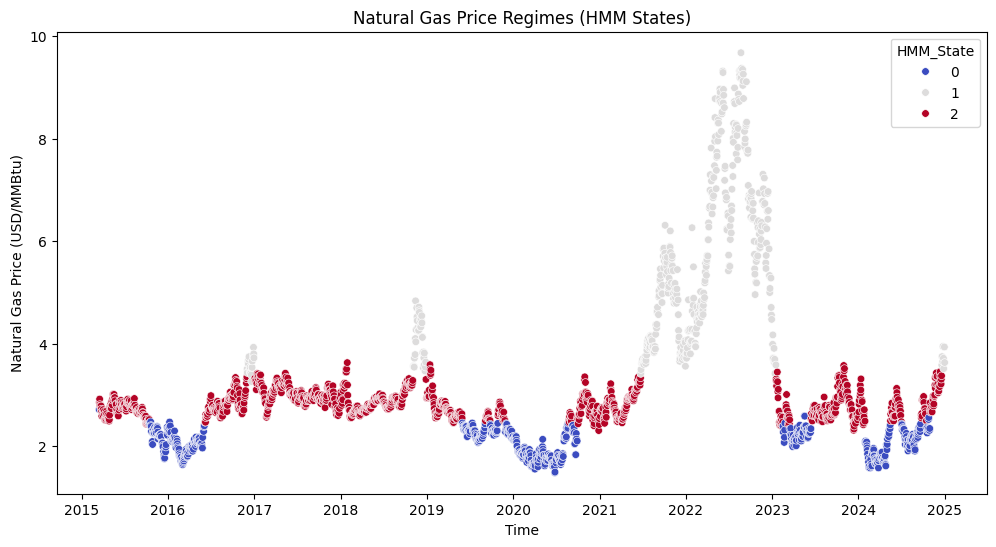

In [5]:
# --- 6. Hidden Markov Model (HMM) ---

# Ensure the natural gas data is 1-D for fitting and plotting
natural_gas_vals = np.ravel(df["NATURAL_GAS"].values)

# Fit the model
hmm = GaussianHMM(n_components=3, covariance_type="diag", n_iter=200)
hmm.fit(natural_gas_vals.reshape(-1, 1))
hidden_states = hmm.predict(natural_gas_vals.reshape(-1, 1))

# Store in DataFrame
df["HMM_State"] = hidden_states

# Plot — make sure everything passed to seaborn is 1-D
plt.figure(figsize=(12,6))
sns.scatterplot(
    x=df.index,
    y=np.ravel(df["NATURAL_GAS"].values),
    hue=df["HMM_State"],
    palette="coolwarm",
    s=30
)
plt.title("Natural Gas Price Regimes (HMM States)")
plt.xlabel("Time")
plt.ylabel("Natural Gas Price (USD/MMBtu)")
plt.show()

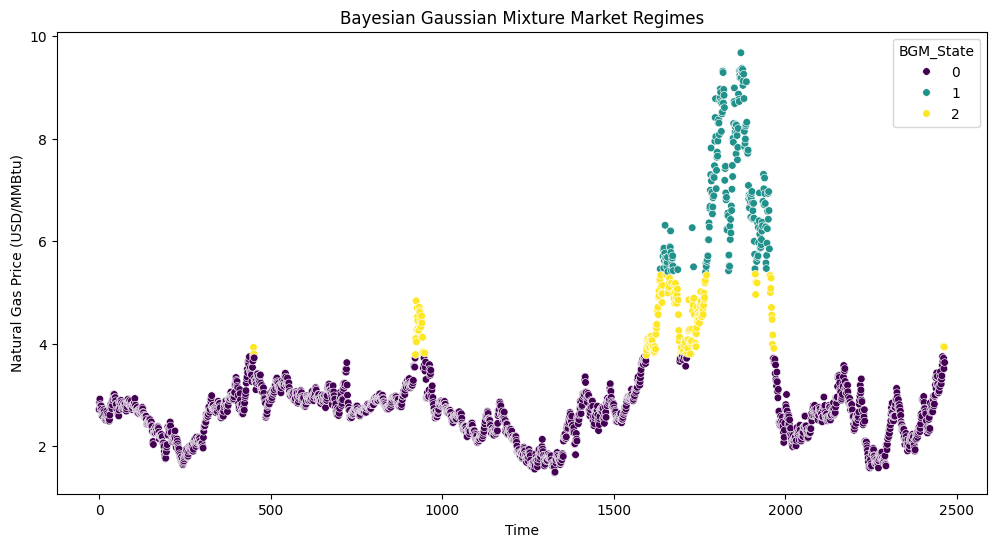

In [6]:
# --- 7. Bayesian Gaussian Mixture (BGM) ---

# Make sure natural gas prices are strictly 1-D
natural_gas_vals = np.ravel(df["NATURAL_GAS"].values)

# Fit Bayesian Gaussian Mixture model
bgm = BayesianGaussianMixture(n_components=3, covariance_type="diag", n_init=5)
bgm.fit(natural_gas_vals.reshape(-1, 1))
bgm_states = bgm.predict(natural_gas_vals.reshape(-1, 1))

# Store the states in DataFrame
df["BGM_State"] = bgm_states

# Plot regimes — ensure all arrays are 1-D
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=np.arange(len(natural_gas_vals)),
    y=natural_gas_vals,
    hue=df["BGM_State"].astype(int),
    palette="viridis",
    s=30
)
plt.title("Bayesian Gaussian Mixture Market Regimes")
plt.xlabel("Time")
plt.ylabel("Natural Gas Price (USD/MMBtu)")
plt.show()

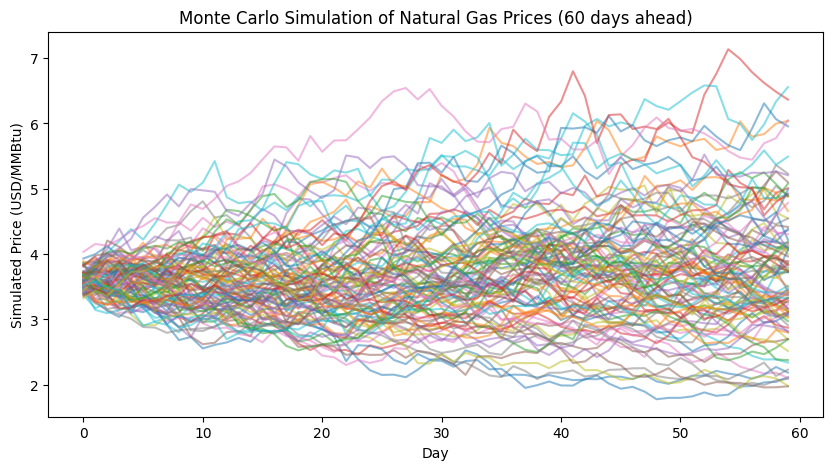

In [7]:
# --- 8. Monte Carlo Simulation for Natural Gas Prices ---

import numpy as np
import matplotlib.pyplot as plt

# Extract and clean natural gas prices
natural_gas_prices = df["NATURAL_GAS"].values.flatten()

# Calculate daily log returns
log_returns = np.diff(np.log(natural_gas_prices))
mu = np.mean(log_returns)
sigma = np.std(log_returns)

# Simulation parameters
n_simulations = 100     # number of simulated paths
n_days = 60             # days to simulate

# Initialize matrix for simulations
simulations = np.zeros((n_days, n_simulations))

# Run simulations
for sim in range(n_simulations):
    price_series = [natural_gas_prices[-1]]  # start from last known price
    for day in range(1, n_days + 1):
        # geometric Brownian motion formula
        price = price_series[-1] * np.exp((mu - 0.5 * sigma**2) + sigma * np.random.normal())
        price_series.append(price)
    # Ensure conversion to numpy array for assignment
    simulations[:, sim] = np.array(price_series[1:])

# Plot all simulated paths
plt.figure(figsize=(10, 5))
plt.plot(simulations, alpha=0.5)
plt.title("Monte Carlo Simulation of Natural Gas Prices (60 days ahead)")
plt.xlabel("Day")
plt.ylabel("Simulated Price (USD/MMBtu)")
plt.show()

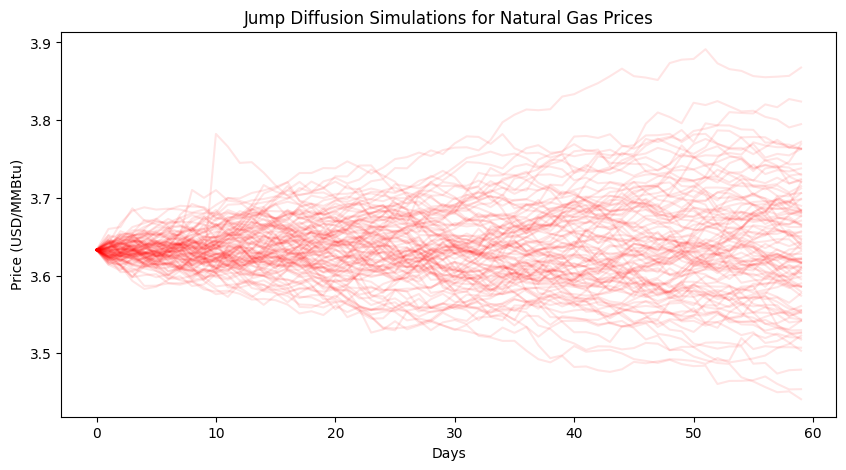

In [8]:
# --- Jump Diffusion Model ---

def jump_diffusion_sim(S0, mu, sigma, lamb, mu_j, sigma_j, T=1, steps=252, n_sims=100):
    dt = T / steps
    prices = np.zeros((steps, n_sims))
    for sim in range(n_sims):
        prices[0, sim] = S0
        for t in range(1, steps):
            N = np.random.poisson(lamb * dt)
            # If no jumps, J should be 0.0
            J = np.sum(np.random.normal(mu_j, sigma_j, N)) if N > 0 else 0.0
            drift = (mu - 0.5 * sigma**2) * dt
            diffusion = sigma * np.sqrt(dt) * np.random.normal()
            prices[t, sim] = prices[t-1, sim] * np.exp(drift + diffusion + J)
    return prices

# compute parameters (ensure scalars)
mu = float(df["NATURAL_GAS"].pct_change().mean())
sigma = float(df["NATURAL_GAS"].pct_change().std())
S0 = float(df["NATURAL_GAS"].iloc[-1])

# simulate using the notebook's n_days and n_simulations (already defined in earlier cells)
# use T = n_days / 252 so steps correspond to n_days
jd_prices = jump_diffusion_sim(S0, mu, sigma, lamb=0.1, mu_j=-0.02, sigma_j=0.05, T=n_days/252, steps=n_days, n_sims=n_simulations)

plt.figure(figsize=(10,5))
plt.plot(jd_prices, alpha=0.1, color='red')
plt.title("Jump Diffusion Simulations for Natural Gas Prices")
plt.xlabel("Days")
plt.ylabel("Price (USD/MMBtu)")
plt.show()

In [9]:
# --- NLTK Sentiment Analysis ---
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download required NLTK data
nltk.download('vader_lexicon', quiet=True)

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

headlines = [
    "Natural gas prices spike on winter demand surge",
    "LNG export concerns pressure natural gas markets",
    "Energy crisis boosts natural gas prices globally",
]

def get_nltk_sentiment(texts):
    sentiments = []
    for text in texts:
        scores = sia.polarity_scores(text)
        compound = scores['compound']
        
        # Classify based on compound score
        if compound >= 0.05:
            sentiment = "Positive"
        elif compound <= -0.05:
            sentiment = "Negative"
        else:
            sentiment = "Neutral"
        sentiments.append(sentiment)
    return sentiments

sentiments = get_nltk_sentiment(headlines)
for h, s in zip(headlines, sentiments):
    print(f"{h} → {s}")

Natural gas prices spike on winter demand surge → Positive
LNG export concerns pressure natural gas markets → Positive
Energy crisis boosts natural gas prices globally → Positive


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0029 - val_loss: 0.0146
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0013 - val_loss: 0.0103
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0014 - val_loss: 0.0113
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0011 - val_loss: 0.0101
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 9.5035e-04 - val_loss: 0.0108
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 8.3356e-04 - val_loss: 0.0087
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 9.0904e-04 - val_loss: 0.0136
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 9.5938e-04 - val_loss: 0.0082
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 8.2465e-04 - val_loss: 0.0075
Epoch 10/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 7.6770e-04 - val_loss: 0.0071
Epoch 11/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 6.0533e-04 - val_loss: 0.0065
Epoch 12/30
55/55 ━━━━━━━━━━━━━━━━━

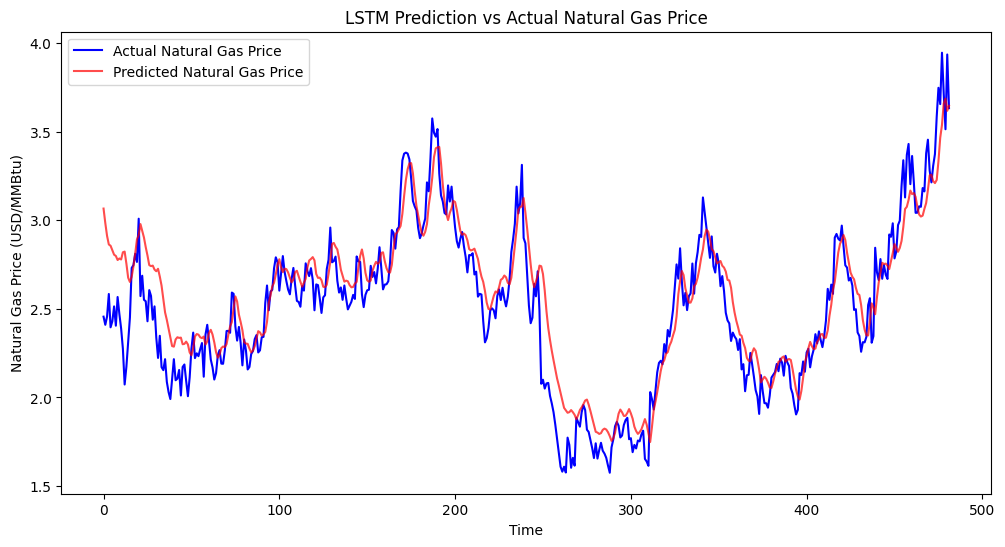

RMSE: 0.1855


In [10]:
# --- 9. LSTM Training and Natural Gas Price Prediction ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# --- Prepare Data ---

# Select numerical columns (excluding date if any)
features = df.select_dtypes(include=[np.number]).copy()

# Choose your target column here
target_col = "NATURAL_GAS"  # <-- change to "SILVER" later if needed

if target_col not in features.columns:
    raise ValueError(f"{target_col} column not found in dataframe. Available columns: {list(features.columns)}")

# Fill NaN values
features = features.fillna(method='ffill').fillna(method='bfill')

# Scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# Create sequences for LSTM
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i, features.columns.get_loc(target_col)])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences(scaled_data, seq_len)

# Split into train/test (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Build LSTM Model ---

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

# --- Make Predictions ---
y_pred = model.predict(X_test)

# Inverse transform predictions & actuals to original scale
scaler_for_target = MinMaxScaler()
scaler_for_target.fit(features[[target_col]])
y_test_rescaled = scaler_for_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler_for_target.inverse_transform(y_pred)

# --- Plot Predicted vs Actual ---
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Natural Gas Price', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Natural Gas Price', color='red', alpha=0.7)
plt.title("LSTM Prediction vs Actual Natural Gas Price")
plt.xlabel("Time")
plt.ylabel("Natural Gas Price (USD/MMBtu)")
plt.legend()
plt.show()

# --- RMSE ---
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"RMSE: {rmse:.4f}")
from sklearn.metrics import r2_score

# Calculate R²
#r2 = r2_score(y_test, predicted_prices)
#print(f"R² Score: {r2:.4f}")

In [11]:
# --- Model Evaluation Metrics ---

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Try to detect prediction variable
try:
    y_pred_eval = predicted_prices
except NameError:
    try:
        y_pred_eval = predictions
    except NameError:
        try:
            y_pred_eval = y_pred
        except NameError:
            raise NameError("Couldn't find prediction variable. Make sure your LSTM cell outputs predictions.")

# Ensure both y_test and predictions are 1D arrays
y_test = np.array(y_test).flatten()
y_pred_eval = np.array(y_pred_eval).flatten()

# Calculate metrics
r2 = r2_score(y_test, y_pred_eval)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_eval))
mae = mean_absolute_error(y_test, y_pred_eval)

# Print results
print("📊 Model Performance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

📊 Model Performance Metrics:
R² Score: 0.8353
RMSE: 0.0226
MAE: 0.0172


In [12]:
# --- Save Future Predictions to CSV ---

import pandas as pd
from datetime import datetime, timedelta

# Get the last date from the original data
last_date = df.index[-1]

# Generate future dates for predictions (same number as test predictions)
future_dates = [last_date + timedelta(days=i) for i in range(1, len(y_pred_rescaled) + 1)]

# Create a DataFrame with future predictions
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': y_pred_rescaled.flatten()
})

# Save to CSV
output_filename = f'natural_gas_future_predictions_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
future_predictions_df.to_csv(output_filename, index=False)
print(f"✅ Future predictions saved to: {output_filename}")
print(f"📊 Total predictions: {len(future_predictions_df)}")
print(f"📈 Price range: ${future_predictions_df['Predicted_Price'].min():.2f} - ${future_predictions_df['Predicted_Price'].max():.2f}")
print("\nFirst 5 predictions:")
print(future_predictions_df.head())


✅ Future predictions saved to: natural_gas_future_predictions_20251111_202956.csv
📊 Total predictions: 482
📈 Price range: $1.75 - $3.69

First 5 predictions:
        Date  Predicted_Price
0 2025-01-01         3.066254
1 2025-01-02         2.984069
2 2025-01-03         2.911674
3 2025-01-04         2.863598
4 2025-01-05         2.856267
